In [ ]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from preprocessor import get_training_data, mem_check

In [ ]:
# list devices tensorflow can see
tf.config.list_physical_devices()

# Preprocessing and Feature Engineering Data

In [ ]:
directory = "caltech-101/101_ObjectCategories"
img_height = 128
img_width = 128

exclude_classes = {
    "airplanes",
    "Motorbikes",
    "Faces",
    "Faces_easy",
    "watch",
    "Leopards",
}

x_train, x_test, y_train, y_test, class_names = get_training_data(
    "cnn", directory, img_height, img_width, exclude_classes
)

In [ ]:
print("Class Names:", class_names)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

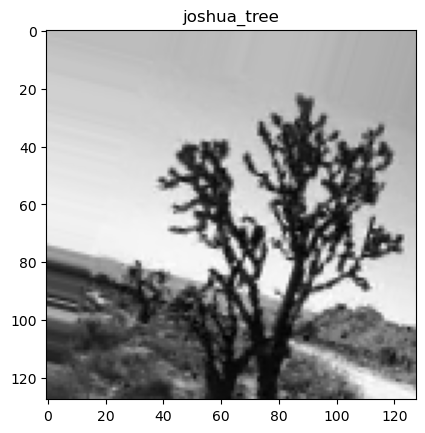

In [ ]:
# shows a random augmented image - same thing in 'exploratory_data_analysis.ipynb' but added here too to ensure the data is loaded correctly
index = random.randint(0, len(x_train))
plt.imshow(x_train[index].astype(np.float32))
plt.title(class_names[y_train[index]])
plt.show()

# CNN Model

In [ ]:
mem_check()

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 512)               65028608  
                                                                 
 dropout (Dropout)           (None, 512)               0

In [17]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [18]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model_fix_overfitting.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="max",
    restore_best_weights=True,
    verbose=1,
)

history_basic = model.fit(
    x_train, y_train, epochs=100, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
244/244 [==============================] - ETA: 0s - loss: 10.1655 - accuracy: 0.0145
Epoch 1: val_accuracy improved from -inf to 0.00822, saving model to best_model_fix_overfitting.h5
244/244 [==============================] - 13s 46ms/step - loss: 10.1655 - accuracy: 0.0145 - val_loss: 4.5550 - val_accuracy: 0.0082
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 4.5129 - accuracy: 0.0258
Epoch 2: val_accuracy improved from 0.00822 to 0.01028, saving model to best_model_fix_overfitting.h5
244/244 [==============================] - 9s 36ms/step - loss: 4.5129 - accuracy: 0.0258 - val_loss: 4.5484 - val_accuracy: 0.0103
Epoch 3/100
243/244 [============================>.] - ETA: 0s - loss: 4.4523 - accuracy: 0.0354
Epoch 3: val_accuracy improved from 0.01028 to 0.03135, saving model to best_model_fix_overfitting.h5
244/244 [==============================] - 8s 35ms/step - loss: 4.4524 - accuracy: 0.0353 - val_loss: 4.4932 - val_accuracy: 0.0313
Epoch 4

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 1s 9ms/step - loss: 5.8840 - accuracy: 0.1402
Test accuracy: 0.14021381735801697


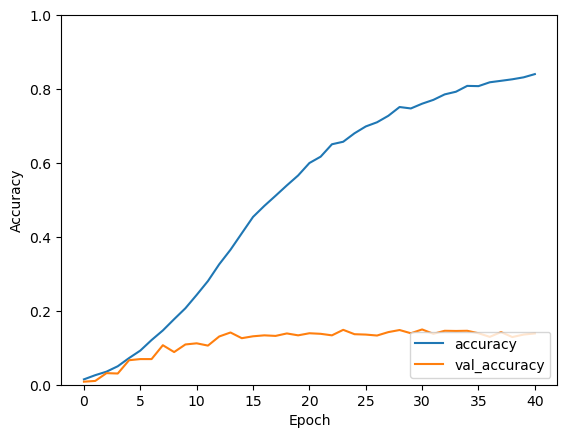

In [20]:
# plot training history
plt.plot(history_basic.history['accuracy'], label='accuracy')
plt.plot(history_basic.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Use transfer learning to improve results and stop overfitting

In [ ]:
mem_check()

In [21]:
base_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

batch_size = 32

learning_rate = 0.001 * (batch_size / 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_transfer_learning_model_fix_overfitting.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

history_transfer1 = model.fit(
    x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
244/244 [==============================] - ETA: 0s - loss: 4.1015 - accuracy: 0.0830
Epoch 1: val_accuracy improved from -inf to 0.32528, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 17s 56ms/step - loss: 4.1015 - accuracy: 0.0830 - val_loss: 3.2001 - val_accuracy: 0.3253
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 3.2378 - accuracy: 0.2163
Epoch 2: val_accuracy improved from 0.32528 to 0.47842, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 13s 52ms/step - loss: 3.2371 - accuracy: 0.2163 - val_loss: 2.4426 - val_accuracy: 0.4784
Epoch 3/100
243/244 [============================>.] - ETA: 0s - loss: 2.7656 - accuracy: 0.2971
Epoch 3: val_accuracy improved from 0.47842 to 0.53135, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 12s 51ms/step - loss: 2.7660 - accuracy: 0.

In [23]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 3s 43ms/step - loss: 1.4566 - accuracy: 0.6538
Test accuracy: 0.6537829041481018


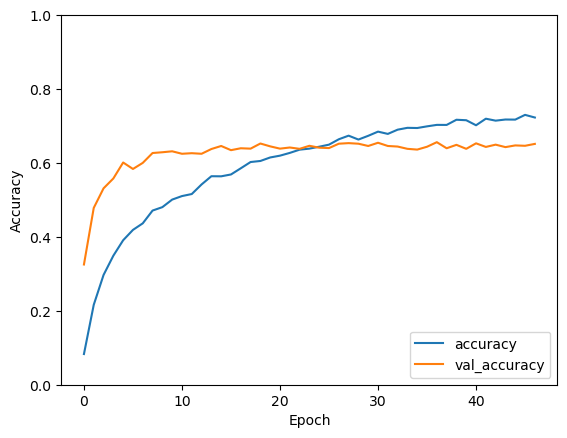

In [24]:
# plot training history
plt.plot(history_transfer1.history['accuracy'], label='accuracy')
plt.plot(history_transfer1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 

As we can see above, using the pretrained model has helped stop the overfitting, but our evaluation accuracy is plateauing at just over 60%. Let's improve that by adjusting the layers.

In [25]:
base_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

base_model.trainable = False

# unfreeze the last layers of the base model
for layer in base_model.layers[-8:]:
    layer.trainable = True

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

batch_size = 32

learning_rate = 0.001 * (batch_size / 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_transfer_learning_model_fix_overfitting.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1,
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    restore_best_weights=True,
    verbose=1,
)

reduce_learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-6,
    verbose=1
)

history_transfer2 = model.fit(
    x_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.2, callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/100
243/244 [============================>.] - ETA: 0s - loss: 4.9971 - accuracy: 0.0927
Epoch 1: val_accuracy improved from -inf to 0.28366, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 14s 53ms/step - loss: 4.9959 - accuracy: 0.0930 - val_loss: 3.5694 - val_accuracy: 0.2837
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 3.2825 - accuracy: 0.2836
Epoch 2: val_accuracy improved from 0.28366 to 0.44399, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 11s 45ms/step - loss: 3.2826 - accuracy: 0.2836 - val_loss: 2.6870 - val_accuracy: 0.4440
Epoch 3/100
243/244 [============================>.] - ETA: 0s - loss: 2.7475 - accuracy: 0.3866
Epoch 3: val_accuracy improved from 0.44399 to 0.49538, saving model to best_transfer_learning_model_fix_overfitting.h5
244/244 [==============================] - 11s 45ms/step - loss: 2.7471 - accuracy: 0.

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

76/76 [==============================] - 3s 43ms/step - loss: 1.4127 - accuracy: 0.7015
Test accuracy: 0.7014802694320679


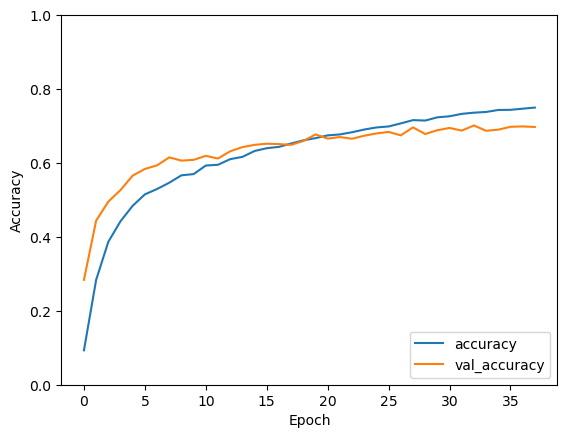

In [28]:
# plot training history
plt.plot(history_transfer2.history['accuracy'], label='accuracy')
plt.plot(history_transfer2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show() 

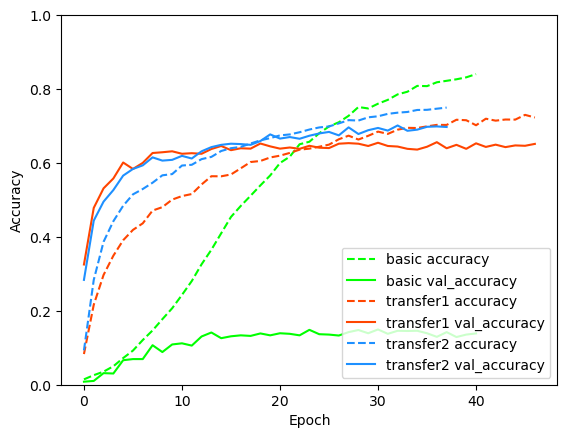

In [ ]:
plt.plot(history_basic.history['accuracy'], label='basic accuracy', color='#00FF00', linestyle='dashed')
plt.plot(history_basic.history['val_accuracy'], label = 'basic val_accuracy', color='#00FF00')
plt.plot(history_transfer1.history['accuracy'], label='transfer1 accuracy', color='#FF4500', linestyle='dashed')
plt.plot(history_transfer1.history['val_accuracy'], label = 'transfer1 val_accuracy', color='#FF4500')
plt.plot(history_transfer2.history['accuracy'], label='transfer2 accuracy', color='#1E90FF', linestyle='dashed')
plt.plot(history_transfer2.history['val_accuracy'], label = 'transfer2 val_accuracy', color='#1E90FF')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()